In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
train_data = datasets.FashionMNIST(
    root='./',
    train = True,
    download=True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root='./',
    train = False,
    download=True,
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4676422.48it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170610.60it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3313585.68it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5624453.50it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



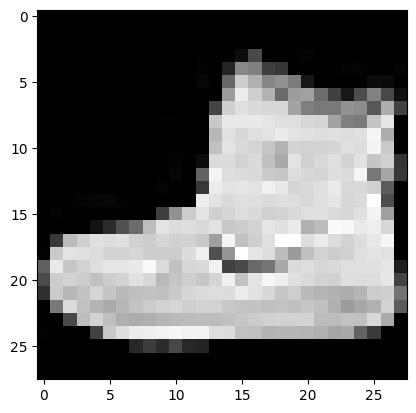

In [5]:
plt.imshow(train_data[0][0][0],cmap='gray')

In [6]:
from torch.utils.data import DataLoader as DL

BATCH_SIZE = 32

loader_train_data = DL(train_data,batch_size=BATCH_SIZE,shuffle=True)
loader_test_data = DL(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [7]:
train_features,train_labels = next(iter(loader_train_data))

train_features.size(),train_labels.size()

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'This is a picture of a Sneaker')

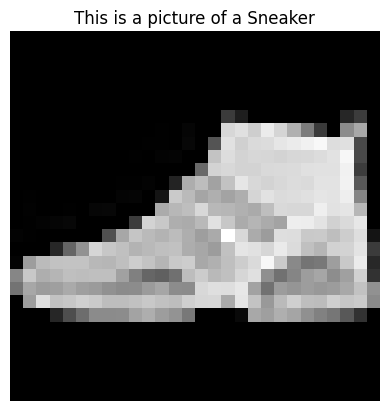

In [8]:
img = train_features[0].squeeze()
label = train_labels[0].squeeze()

plt.imshow(img,cmap='gray')
plt.axis('Off')
plt.title(f'This is a picture of a {train_data.classes[label]}')

In [9]:
def accuracy(y_pred,y_real):
    ratio_acc = torch.eq(y_pred,y_real).sum().item()
    return np.round(100*ratio_acc/y_real.size()[0],1)

def eval_model(model: torch.nn.Module,
               data_loader: DL,
               loss_function: nn.Module,
               accuracy_function):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss += loss_function(y_pred, y)
            acc += accuracy_function(y_pred.argmax(dim=1),
                                y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_loss": loss.item(),
            "model_acc": acc}

In [10]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_function,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_function(y_pred, y)
        train_loss += loss
        train_acc += accuracy_function(y_pred.argmax(dim=1),
                                 y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.2f}%")

In [9]:
HIDDEN_LAYER_SIZE =10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(train_features.shape[-2]*train_features.shape[-1],HIDDEN_LAYER_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_LAYER_SIZE,train_labels.shape[0]),
    nn.ReLU()
).to(device)


loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)


EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}\n-------")
    train_step(model,
               loader_train_data,
               loss_func,
               optimizer,
               accuracy,
               device)

    test_eval = eval_model(model=model, data_loader= loader_test_data, loss_function=loss_func,accuracy_function=accuracy)

    print(f'test avg loss : {test_eval["model_loss"]:.2f} avg. acc. '\
              +f': {test_eval["model_acc"]:.2f}\n\n\n')

Epoch: 0
-------
Train loss: 1.060 | Train accuracy: 69.55%
test avg loss : 0.86 avg. acc. : 75.34



Epoch: 1
-------
Train loss: 0.833 | Train accuracy: 76.15%
test avg loss : 0.81 avg. acc. : 76.91



Epoch: 2
-------
Train loss: 0.804 | Train accuracy: 77.01%
test avg loss : 0.81 avg. acc. : 77.01



Epoch: 3
-------
Train loss: 0.793 | Train accuracy: 77.45%
test avg loss : 0.86 avg. acc. : 75.50



Epoch: 4
-------
Train loss: 0.779 | Train accuracy: 77.86%
test avg loss : 0.83 avg. acc. : 76.14



Epoch: 5
-------
Train loss: 0.772 | Train accuracy: 77.93%
test avg loss : 0.83 avg. acc. : 76.35



Epoch: 6
-------
Train loss: 0.767 | Train accuracy: 78.16%
test avg loss : 0.80 avg. acc. : 77.21



Epoch: 7
-------
Train loss: 0.542 | Train accuracy: 82.46%
test avg loss : 0.48 avg. acc. : 83.32



Epoch: 8
-------
Train loss: 0.442 | Train accuracy: 84.49%
test avg loss : 0.48 avg. acc. : 82.85



Epoch: 9
-------
Train loss: 0.432 | Train accuracy: 84.82%
test avg loss : 0.46 a

In [15]:
test_image_batch = torch.randn(size=(32,3,28,28)) ## A batch of randomly generated images with 3 channels

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=16,
                       kernel_size=5,
                       stride=1,
                       padding=1)

## the Width (and the height) of the image should follow {1+ [(W_in - kernel_size)+2*padding]/stride}
## For this specific case WxH would be : 1 + [(28-5)+2*1]/1 = 26
conv_layer(test_image_batch).size()

torch.Size([32, 16, 26, 26])

In [11]:
def W_H_calculator(length,
                   kernel_size,
                   stride,
                   padding):
    return 1 + ((length-kernel_size)+2*padding)/stride

In [12]:
class Model_ConvNN(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 conv_kernel_size,
                 conv_stride,
                 pool_kernel_size,
                 pool_stride,
                 padding,
                 num_classes):
        super().__init__()

        W_out = train_data[0][0].size()[-1]


        self.conv1 = nn.Sequential(
                        nn.Conv2d(
                                    in_channels=in_features,
                                    out_channels=out_features,
                                    kernel_size=conv_kernel_size[0],
                                    stride=conv_stride,
                                    padding=padding
                    ),
                        nn.ReLU(),
                        nn.Conv2d(
                                    in_channels=out_features,
                                    out_channels=out_features,
                                    kernel_size=conv_kernel_size[0],
                                    stride=conv_stride,
                                    padding=padding
                        ),
                        nn.ReLU(),
                        nn.MaxPool2d(
                            kernel_size=pool_kernel_size,
                            stride=pool_stride
                        ))
        W_out = W_H_calculator(W_out,conv_kernel_size[0],conv_stride,padding)
        W_out = W_H_calculator(W_out,conv_kernel_size[0],conv_stride,padding)
        W_out = int(W_H_calculator(W_out,pool_kernel_size,pool_stride,0))

        self.conv2 = nn.Sequential(
                        nn.Conv2d(
                                    in_channels=out_features,
                                    out_channels=out_features*2,
                                    kernel_size=conv_kernel_size[1],
                                    stride=conv_stride,
                                    padding=padding
                    ),
                        nn.ReLU(),
                        nn.Conv2d(
                                    in_channels=out_features*2,
                                    out_channels=out_features*2,
                                    kernel_size=conv_kernel_size[1],
                                    stride=conv_stride,
                                    padding=padding
                        ),
                        nn.ReLU(),
                        nn.MaxPool2d(
                            kernel_size=pool_kernel_size,
                            stride=pool_stride
                        ))
        W_out = W_H_calculator(W_out,conv_kernel_size[1],conv_stride,padding)
        W_out = W_H_calculator(W_out,conv_kernel_size[1],conv_stride,padding)
        W_out = int(W_H_calculator(W_out,pool_kernel_size,pool_stride,0))

        self.fully_connected  = nn.Sequential(
            nn.Flatten(),
            nn.Linear(W_out*W_out*out_features*2 , num_classes)
        )

    def forward(self, x: torch.Tensor):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fully_connected(x)

        return x


In [13]:
model = Model_ConvNN(
    train_data[0][0].size()[0],
    16,
    [3,5],1,
    2,2,
    1,len(train_data.classes)
)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)


EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch}\n-------")
    train_step(model,
               loader_train_data,
               loss_func,
               optimizer,
               accuracy,
               device)

    test_eval = eval_model(model=model, data_loader= loader_test_data, loss_function=loss_func,accuracy_function=accuracy)

    print(f'test avg loss : {test_eval["model_loss"]:.2f} avg. acc. '\
              +f': {test_eval["model_acc"]:.2f}%\n\n\n')

Epoch: 0
-------
Train loss: 0.541 | Train accuracy: 80.24%
test avg loss : 0.40 avg. acc. : 84.47%



Epoch: 1
-------
Train loss: 0.319 | Train accuracy: 88.42%
test avg loss : 0.33 avg. acc. : 87.96%



Epoch: 2
-------
Train loss: 0.274 | Train accuracy: 90.16%
test avg loss : 0.28 avg. acc. : 89.51%



Epoch: 3
-------
Train loss: 0.247 | Train accuracy: 91.11%
test avg loss : 0.28 avg. acc. : 89.56%



Epoch: 4
-------
Train loss: 0.229 | Train accuracy: 91.72%
test avg loss : 0.27 avg. acc. : 90.18%



Epoch: 5
-------
Train loss: 0.216 | Train accuracy: 92.18%
test avg loss : 0.24 avg. acc. : 91.11%



Epoch: 6
-------
Train loss: 0.201 | Train accuracy: 92.70%
test avg loss : 0.26 avg. acc. : 91.06%



Epoch: 7
-------
Train loss: 0.188 | Train accuracy: 93.16%
test avg loss : 0.24 avg. acc. : 91.63%



Epoch: 8
-------
Train loss: 0.179 | Train accuracy: 93.46%
test avg loss : 0.26 avg. acc. : 90.83%



Epoch: 9
-------
Train loss: 0.172 | Train accuracy: 93.70%
test avg loss

In [1]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 9.9 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [14]:
y_pred_tensor = []
with torch.inference_mode():
    for X,y in loader_test_data:
        X,y = X.to(device), y.to(device)
        y_logits = model(X).to('cpu')
        y_pred_tensor.append(y_logits.argmax(dim=1))

y_pred_tensor = torch.cat(y_pred_tensor)

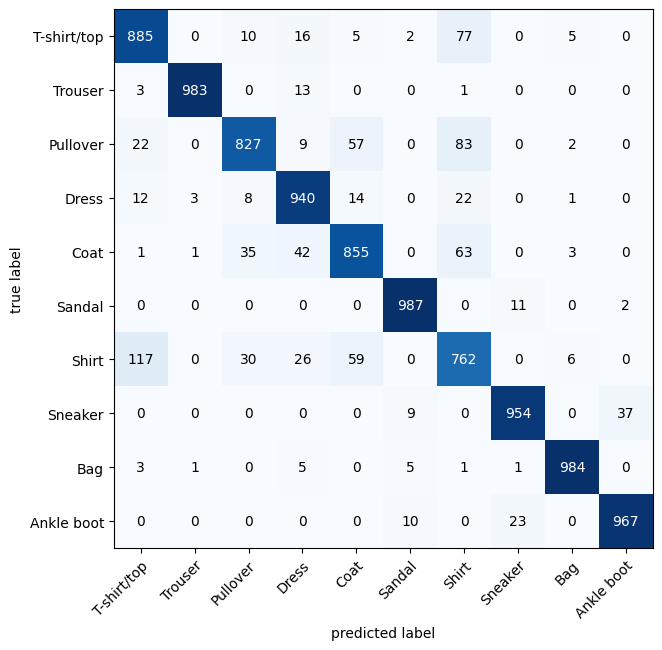

In [16]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(train_data.classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=train_data.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);